In [1]:
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import shutil as sh
from collections import defaultdict

tf.logging.set_verbosity(tf.logging.ERROR)

## Get dataframes

In [2]:
train_data = pd.read_csv('train.csv').drop(columns='PassengerId')
test_data = pd.read_csv('test.csv').drop(columns='PassengerId')

In [3]:
train_data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Create 'married' columns depending on name formating

#### Name prefixes

In [4]:
train_data['Married_female'] = train_data['Name'].apply(lambda x: 1 if x.find('Mrs') != -1 else 0)
test_data['Married_female'] = test_data['Name'].apply(lambda x: 1 if x.find('Mrs') != -1 else 0)

In [5]:
for i in range(len(train_data)):
    name = train_data['Name'][i]
    if name[-1:].find('J') != -1:
        print(name)

McCarthy, Mr. Timothy J
Fynney, Mr. Joseph J
Davies, Mr. Alfred J
Knight, Mr. Robert J
Lesurer, Mr. Gustave J
Moran, Mr. Daniel J
Kilgannon, Mr. Thomas J


In [6]:
for name in train_data['Name']:
    if name.find('Jr') >= 0:
        print(name)

Hood, Mr. Ambrose Jr
Johnson, Mr. William Cahoone Jr
Sage, Mr. George John Jr
Elias, Mr. Joseph Jr
Davies, Master. John Morgan Jr
Thayer, Mr. John Borland Jr
Kimball, Mr. Edwin Nelson Jr
Andrews, Mr. Thomas Jr
Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)
Sutehall, Mr. Henry Jr


#### Get lists of married males

In [7]:
married_males_train = []

for text in train_data['Name']:
    if text.find('Mrs.') < 0:
        continue
    words_list = text.split(', Mrs.')
    surname = words_list[0]
    second_word = words_list[1]
    words_list = second_word.split('(')
    name = words_list[0]
    if name == ' ':
        continue
    name = name.strip()
    surname = surname.strip()
    married_males_train.append(surname + ', Mr. ' + name)

In [8]:
married_males_test = []

for text in test_data['Name']:
    if text.find('Mrs.') < 0:
        continue
    words_list = text.split(', Mrs.')
    surname = words_list[0]
    second_word = words_list[1]
    words_list = second_word.split('(')
    name = words_list[0]
    if name == ' ':
        continue
    name = name.strip()
    surname = surname.strip()
    married_males_test.append(surname + ', Mr. ' + name)

#### Create new columns

In [9]:
train_data['Married_male'] = train_data['Name'].apply(lambda x: 1 if x in married_males_train else 0)
test_data['Married_male'] = test_data['Name'].apply(lambda x: 1 if x in married_males_test else 0)

In [10]:
train_data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Married_female,Married_male
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,0
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,0


## Fill missing age values depending on name formating

In [11]:
train_data['Young'] = train_data.apply(
    lambda x: 1 if x.Name[-1:] == 'J' or x.Name.find('Jr') >= 0 or 12 < x.Age <= 25 else 0, axis=1)

test_data['Young'] = test_data.apply(
    lambda x: 1 if x.Name[-1:] == 'J' or x.Name.find('Jr') >= 0 or 12 < x.Age <= 25 else 0, axis=1)

In [12]:
train_data['Age'] = train_data.apply(
    lambda x: 25 if np.isnan(x.Age) and x.Young == 1 else 40 if np.isnan(x.Age) else x.Age, axis=1)

test_data['Age'] = test_data.apply(
    lambda x: 25 if np.isnan(x.Age) and x.Young == 1 else 40 if np.isnan(x.Age) else x.Age, axis=1)

## Bucketize ages according to chosen bucket ranges

In [13]:
LOW = 7
HIGH = 65

train_data['Age'] = train_data.apply(lambda x: 'LOW' if x.Age < LOW else float(x.Age), axis=1)
train_data['Age'] = train_data.apply(lambda x: 'MID' if isinstance(x.Age, float) and HIGH > x.Age >= LOW else x.Age, axis=1)
train_data['Age'] = train_data.apply(lambda x: 'HIGH' if isinstance(x.Age, float) and x.Age >= HIGH else x.Age, axis=1)

test_data['Age'] = test_data.apply(lambda x: 'LOW' if x.Age < LOW else float(x.Age), axis=1)
test_data['Age'] = test_data.apply(lambda x: 'MID' if isinstance(x.Age, float) and HIGH > x.Age >= LOW else x.Age, axis=1)
test_data['Age'] = test_data.apply(lambda x: 'HIGH' if isinstance(x.Age, float) and x.Age >= HIGH else x.Age, axis=1)

In [14]:
# check results

train_data.groupby(by='Age')['Survived'].agg([np.ma.count, np.median, np.mean]).sort_values(by='mean')

,count,median,mean
Age,,,
HIGH,11,0,0.090909
MID,833,0,0.369748
LOW,47,1,0.702128


In [15]:
# bucketize ages

dummy = pd.get_dummies(train_data['Age'], prefix='Age', prefix_sep='_')
ages = list(dummy)

train_data[ages] = dummy[ages]

In [16]:
dummy = pd.get_dummies(test_data['Age'], prefix='Age', prefix_sep='_')
ages = list(dummy)

test_data[ages] = dummy[ages]

In [17]:
train_data.drop(columns='Age', inplace=True)
test_data.drop(columns='Age', inplace=True)

In [18]:
train_data.head(5)

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Married_female,Married_male,Young,Age_HIGH,Age_LOW,Age_MID
0,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C85,C,1,0,0,0,0,1
2,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,0,0,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,C123,S,1,0,0,0,0,1
4,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,NaN,S,0,0,0,0,0,1


## Check for columns with missing data

In [19]:
for col in train_data:
    if train_data[col].isna().any():
        print(col)

Cabin
Embarked


In [20]:
for col in test_data:
    if test_data[col].isna().any():
        print(col)

Fare
Cabin


In [21]:
# fill missing 'Fare' values by zeros

test_data['Fare'].fillna(0.0, inplace=True)

## Create mappings and bucketize data

### Sex

In [22]:
# bucketize 'Sex' column data

mapping = {'female':1, 'male':0}

train_data['Sex'].replace(to_replace=mapping, inplace=True)
test_data['Sex'].replace(to_replace=mapping, inplace=True)

### Ticket

In [23]:
# set numeric ticket values to 'Reg'

train_data['Ticket'] = train_data.apply(lambda x: 'Reg' if x.Ticket.isnumeric() else x.Ticket, axis=1)
test_data['Ticket'] = test_data.apply(lambda x: 'Reg' if x.Ticket.isnumeric() else x.Ticket, axis=1)

In [24]:
# crop non-numeric ticket values to keep only first letter

train_data['Ticket'] = train_data.apply(lambda x: x.Ticket[:1], axis=1)
test_data['Ticket'] = test_data.apply(lambda x: x.Ticket[:1], axis=1)

In [25]:
# get unique ticket values

val, uniq = train_data['Ticket'].factorize()

uniq = list(uniq)
uniq.sort()
print(*uniq)

A C F L P R S W


In [26]:
val, uniq = test_data['Ticket'].factorize()

uniq = list(uniq)
uniq.sort()
print(*uniq)

A C F L P R S W


In [27]:
# ...GET MAPPINGS

mapping_dict = {}
 
uniq_dict = defaultdict(list)

# create dictionary {class: list of prices}
for i in range(len(train_data)):
    uniq_dict[train_data['Ticket'][i]].append(train_data['Survived'][i])

# find mean price value for each class in dictionary
for item in uniq_dict:
    uniq_dict[item] = sum(uniq_dict[item]) / len(uniq_dict[item])

# convert dictionary to list of tuples [(class, mean_price), ...]
dlst = uniq_dict.items()
lst = [*dlst]

# sort list of tuples by mean_price
lst.sort(key=lambda x: x[1])

# convert classes to float coefficients using (mean_price_for_class / max_mean_value)
classes, mean_prices = zip(*lst)
max_mean_price = max(mean_prices)
numeric_class_list = []
for i in range(len(classes)):
    numeric_class_list.append(round(mean_prices[i] / max_mean_price, 3))

# create mapping {class: numeric_class}
mapping = dict(zip(list(classes), numeric_class_list))

mapping

{'A': 0.107,
 'C': 0.527,
 'F': 0.884,
 'L': 0.387,
 'P': 1.0,
 'R': 0.595,
 'S': 0.5,
 'W': 0.238}

In [28]:
# combine S, C and R classes to one single SCR class

train_data['Ticket'] = train_data.apply(lambda x: 'SCR' if x.Ticket in 'SCR' else x.Ticket, axis=1)
test_data['Ticket'] = test_data.apply(lambda x: 'SCR' if x.Ticket in 'SCR' else x.Ticket, axis=1)

In [29]:
# bucketize 'Ticket' columns

dummy = pd.get_dummies(train_data['Ticket'], prefix='Ticket', prefix_sep='_')
tickets = list(dummy)

train_data[tickets] = dummy[tickets]

In [30]:
dummy = pd.get_dummies(test_data['Ticket'], prefix='Ticket', prefix_sep='_')
tickets = list(dummy)

test_data[tickets] = dummy[tickets]

In [31]:
train_data.drop(columns=['Name', 'Ticket'], inplace=True)
test_data.drop(columns=['Name', 'Ticket'], inplace=True)

### Embarked

In [32]:
# ...GET MAPPINGS

mapping_dict = {}
 
uniq_dict = defaultdict(list)

# create dictionary {class: list of prices}
for i in range(len(train_data)):
    uniq_dict[train_data['Embarked'][i]].append(train_data['Survived'][i])

# find mean price value for each class in dictionary
for item in uniq_dict:
    uniq_dict[item] = sum(uniq_dict[item]) / len(uniq_dict[item])

# convert dictionary to list of tuples [(class, mean_price), ...]
dlst = uniq_dict.items()
lst = [*dlst]

#sort list of tuples by mean_price
lst.sort(key=lambda x: x[1])

# convert classes to float coefficients using (mean_price_for_class / max_mean_value)
classes, mean_prices = zip(*lst)
max_mean_price = max(mean_prices)
numeric_class_list = []
for i in range(len(classes)):
    numeric_class_list.append(round(mean_prices[i] / max_mean_price, 3))

# create mapping {class: numeric_class}
mapping = dict(zip(list(classes), numeric_class_list))

mapping

{'C': 0.554, 'Q': 0.39, 'S': 0.337, nan: 1.0}

In [33]:
# drop rows corresponding to missing 'Embarked' data

train_data.dropna(axis=0, subset=['Embarked'], inplace=True)
train_data.reset_index(drop=True, inplace=True)

In [34]:
# bucketize 'Embarked' columns

dummy = pd.get_dummies(train_data['Embarked'], prefix='Embark', prefix_sep='_')
embark = list(dummy)

train_data[embark] = dummy[embark]

In [35]:
dummy = pd.get_dummies(test_data['Embarked'], prefix='Embark', prefix_sep='_')
embark = list(dummy)

test_data[embark] = dummy[embark]

In [36]:
train_data.drop(columns='Embarked', inplace=True)
test_data.drop(columns='Embarked', inplace=True)

In [37]:
# check results

train_data.head(5)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Married_female,Married_male,Young,...,Age_MID,Ticket_A,Ticket_F,Ticket_L,Ticket_P,Ticket_SCR,Ticket_W,Embark_C,Embark_Q,Embark_S
0,0,3,0,1,0,7.2500,NaN,0,0,1,...,1,1,0,0,0,0,0,0,0,1
1,1,1,1,1,0,71.2833,C85,1,0,0,...,1,0,0,0,1,0,0,1,0,0
2,1,3,1,0,0,7.9250,NaN,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,1,1,1,1,0,53.1000,C123,1,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,3,0,0,0,8.0500,NaN,0,0,0,...,1,0,0,0,0,1,0,0,0,1


### Cabin

In [38]:
# fill missing 'Cabin' values with 'N' strings

train_data['Cabin'].fillna('N', inplace=True)
test_data['Cabin'].fillna('N', inplace=True)

In [39]:
# crop values to keep only first letter

train_data['Cabin'] = train_data.apply(lambda x: x.Cabin[:1], axis=1)
test_data['Cabin'] = test_data.apply(lambda x: x.Cabin[:1], axis=1)

In [40]:
# ...GET MAPPINGS

mapping_dict = {}
 
uniq_dict = defaultdict(list)

# create dictionary {class: list of prices}
for i in range(len(train_data)):
    uniq_dict[train_data['Cabin'][i]].append(train_data['Survived'][i])

# find mean price value for each class in dictionary
for item in uniq_dict:
    uniq_dict[item] = sum(uniq_dict[item]) / len(uniq_dict[item])

# convert dictionary to list of tuples [(class, mean_price), ...]
dlst = uniq_dict.items()
lst = [*dlst]

#sort list of tuples by mean_price
lst.sort(key=lambda x: x[1])

# convert classes to float coefficients using (mean_price_for_class / max_mean_value)
classes, mean_prices = zip(*lst)
max_mean_price = max(mean_prices)
numeric_class_list = []
for i in range(len(classes)):
    numeric_class_list.append(round(mean_prices[i] / max_mean_price, 3))

# create mapping {class: numeric_class}
mapping = dict(zip(list(classes), numeric_class_list))

mapping

{'A': 0.616,
 'B': 0.968,
 'C': 0.783,
 'D': 1.0,
 'E': 0.99,
 'F': 0.812,
 'G': 0.66,
 'N': 0.396,
 'T': 0.0}

In [41]:
# combine some of the classes

train_data['Cabin'] = train_data.apply(lambda x: 'EBD' if x.Cabin in 'EBD' else x.Cabin, axis=1)
test_data['Cabin'] = test_data.apply(lambda x: 'EBD' if x.Cabin in 'EBD' else x.Cabin, axis=1)

In [42]:
train_data['Cabin'] = train_data.apply(lambda x: 'AG' if x.Cabin in 'AG' else x.Cabin, axis=1)
test_data['Cabin'] = test_data.apply(lambda x: 'AG' if x.Cabin in 'AG' else x.Cabin, axis=1)

In [43]:
train_data['Cabin'] = train_data.apply(lambda x: 'CF' if x.Cabin in 'CF' else x.Cabin, axis=1)
test_data['Cabin'] = test_data.apply(lambda x: 'CF' if x.Cabin in 'CF' else x.Cabin, axis=1)

In [44]:
train_data['Cabin'] = train_data.apply(lambda x: 'N' if x.Cabin in 'TN' else x.Cabin, axis=1)
test_data['Cabin'] = test_data.apply(lambda x: 'N' if x.Cabin in 'TN' else x.Cabin, axis=1)

In [45]:
# check results

train_data.groupby(by='Cabin')['Survived'].agg([np.ma.count, np.median, np.mean]).sort_values(by='mean')

,count,median,mean
Cabin,,,
N,688,0,0.299419
AG,19,0,0.473684
CF,72,1,0.597222
EBD,110,1,0.745455


In [46]:
# bucketize 'Cabin' column data

dummy = pd.get_dummies(train_data['Cabin'], prefix='Cabin', prefix_sep='_')
cabins = list(dummy)

train_data[cabins] = dummy[cabins]

In [47]:
dummy = pd.get_dummies(test_data['Cabin'], prefix='Cabin', prefix_sep='_')
cabins = list(dummy)

test_data[cabins] = dummy[cabins]

In [48]:
train_data.drop(columns='Cabin', inplace=True)
test_data.drop(columns='Cabin', inplace=True)

### Fare

In [49]:
# bucketize 'Fare' column data according to specified ranges

LOW = 7
MID = 15
HIGH = 80

train_data['Fare'] = train_data.apply(lambda x: 'LOW' if x.Fare < LOW else x.Fare, axis=1)
train_data['Fare'] = train_data.apply(lambda x: 'MID_LOW' if isinstance(x.Fare, np.number) and x.Fare >= LOW and x.Fare < MID else x.Fare, axis=1)
train_data['Fare'] = train_data.apply(lambda x: 'MID_HIGH' if isinstance(x.Fare, np.number) and x.Fare >= MID and x.Fare < HIGH else x.Fare, axis=1)
train_data['Fare'] = train_data.apply(lambda x: 'HIGH' if isinstance(x.Fare, np.number) and x.Fare >= HIGH else x.Fare, axis=1)

test_data['Fare'] = test_data.apply(lambda x: 'LOW' if x.Fare < LOW else x.Fare, axis=1)
test_data['Fare'] = test_data.apply(lambda x: 'MID_LOW' if isinstance(x.Fare, np.number) and x.Fare >= LOW and x.Fare < MID else x.Fare, axis=1)
test_data['Fare'] = test_data.apply(lambda x: 'MID_HIGH' if isinstance(x.Fare, np.number) and x.Fare >= MID and x.Fare < HIGH else x.Fare, axis=1)
test_data['Fare'] = test_data.apply(lambda x: 'HIGH' if isinstance(x.Fare, np.number) and x.Fare >= HIGH else x.Fare, axis=1)

In [51]:
dummy = pd.get_dummies(train_data['Fare'], prefix='Fare', prefix_sep='_')
fares = list(dummy)

train_data[fares] = dummy[fares]

In [52]:
dummy = pd.get_dummies(test_data['Fare'], prefix='Fare', prefix_sep='_')
fares = list(dummy)

test_data[fares] = dummy[fares]

In [53]:
train_data.drop(columns=['Fare'], inplace=True)
test_data.drop(columns=['Fare'], inplace=True)

### Pclass

In [54]:
# bucketize 'Pclass' column data

dummy = pd.get_dummies(train_data['Pclass'], prefix='Pclass', prefix_sep='_')
_class = list(dummy)

train_data[_class] = dummy[_class]

In [55]:
dummy = pd.get_dummies(test_data['Pclass'], prefix='Pclass', prefix_sep='_')
_class = list(dummy)

test_data[_class] = dummy[_class]

In [56]:
train_data.drop(columns=['Pclass'], inplace=True)
test_data.drop(columns=['Pclass'], inplace=True)

In [57]:
# drop 'Young' column since we don't need it anymore

train_data.drop(columns=['Young'], inplace=True)
test_data.drop(columns=['Young'], inplace=True)

### Parch

In [58]:
dummy = pd.get_dummies(train_data['Parch'], prefix='Parch', prefix_sep='_')
parch = list(dummy)
train_data[parch] = dummy[parch]
train_data.drop(columns=['Parch'], inplace=True)

dummy = pd.get_dummies(test_data['Parch'], prefix='Parch', prefix_sep='_')
parch = list(dummy)
test_data[parch] = dummy[parch]
test_data.drop(columns=['Parch'], inplace=True)

### SibSp

In [59]:
dummy = pd.get_dummies(train_data['SibSp'], prefix='SibSp', prefix_sep='_')
sibsp = list(dummy)
train_data[sibsp] = dummy[sibsp]
train_data.drop(columns=['SibSp'], inplace=True)

dummy = pd.get_dummies(test_data['SibSp'], prefix='SibSp', prefix_sep='_')
sibsp = list(dummy)
test_data[sibsp] = dummy[sibsp]
test_data.drop(columns=['SibSp'], inplace=True)

## Check resulting dataframe

In [60]:
# check if train and test data column lists are identical
# drop unique columns

train_col = []

for col in train_data:
    train_col.append(col)
    
test_col = []

for col in test_data:
    test_col.append(col)
    
print(set(train_col) ^ set(test_col))

{'Parch_9', 'Survived'}


In [61]:
# drop unwanted columns

test_data.drop(columns='Parch_9', inplace=True)

In [62]:
train_data.head(10)

,Survived,Sex,Married_female,Married_male,Age_HIGH,Age_LOW,Age_MID,Ticket_A,Ticket_F,Ticket_L,...,Parch_4,Parch_5,Parch_6,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,1,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Create numpy data

In [63]:
# get list of feature columns

TRAIN_COL = list(train_data.drop(columns='Survived'))

In [64]:
# create train, validation and test numpy data

SIZE = 700

train_examples = np.asarray(train_data[TRAIN_COL].iloc[:SIZE,:], dtype=np.float32)
train_labels = np.asarray(train_data['Survived'][:SIZE], dtype=np.int32)
validate_examples = np.asarray(train_data[TRAIN_COL].iloc[SIZE:,:], dtype=np.float32)
validate_labels = np.asarray(train_data['Survived'][SIZE:], dtype=np.int32)
test_examples = np.asarray(test_data[TRAIN_COL], dtype=np.float32)

## Model input functions

In [65]:
# create input functions

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': train_examples},
    y=train_labels,
    batch_size=5,
    num_epochs=1,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': train_examples},
    y=train_labels,
    num_epochs=1,
    shuffle=False)

validate_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': validate_examples},
    y=validate_labels,
    num_epochs=1,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': test_examples},
    num_epochs=1,
    shuffle=False)

## DNN classifier

In [66]:
def dnn_model_fn(features, labels, mode):
    
    reshape_layer_1 = tf.reshape(features['x'], [-1, features['x'].shape[1]])
    
    dense_layer_1 = tf.layers.dense(
        inputs=reshape_layer_1,
        units=100,
        activation=tf.nn.relu)
    
    dropout_layer_1 = tf.layers.dropout(
        inputs=dense_layer_1,
        rate=0.4,
        training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    dense_layer_2 = tf.layers.dense(
        inputs=dropout_layer_1,
        units=100,
        activation=tf.nn.relu)
    
    logits_layer = tf.layers.dense(
        inputs=dense_layer_2,
        units=2)
    
    predictions = {'classes':tf.argmax(input=logits_layer, axis=1)}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels,
        logits=logits_layer)
    
    accuracy = tf.metrics.accuracy(
        labels=labels,
        predictions = predictions['classes'],
        name='accu_op')
    
    tf.summary.histogram('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    eval_metric_ops = {'accuracy':accuracy}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops = eval_metric_ops)

## Configure estimator

In [67]:
OUTDIR = './titanic_train_data'

dnn_classifier = tf.estimator.Estimator(model_fn=dnn_model_fn, model_dir=OUTDIR)

# call method to write train data to OUTDIR
#file_writer = tf.summary.FileWriter(OUTDIR)

## Train function

In [68]:
def train_and_evaluate(estimator, epochs=1, global_steps=1, train_steps=100):
    
    all_train_log = []
    all_validate_log = []
    
    for _ in range(epochs):

        for i in range(1, global_steps + 1, 1):

            estimator.train(input_fn=train_input_fn, steps=train_steps)

            train_log = estimator.evaluate(input_fn=eval_input_fn)
            print('STEP: {} of {}'.format(i, global_steps))
            print('TRAIN: acc={:.8f}\tloss={:.8f}'.format(train_log['accuracy'], train_log['loss']))

            validate_log = estimator.evaluate(input_fn=validate_input_fn)
            print('VALID: acc={:.8f}\tloss={:.8f}'.format(validate_log['accuracy'], validate_log['loss']))

            all_train_log.append(train_log)
            all_validate_log.append(validate_log)
            
    return all_train_log, all_validate_log

## Train

In [69]:
GLOBAL_STEPS = 3
TRAIN_STEPS = 700

train_log, validate_log = train_and_evaluate(
    dnn_classifier,
    global_steps=GLOBAL_STEPS,
    train_steps=TRAIN_STEPS)

STEP: 1 of 3
TRAIN: acc=0.80000001	loss=0.48592484
VALID: acc=0.79365081	loss=0.42578554
STEP: 2 of 3
TRAIN: acc=0.82142860	loss=0.44168225
VALID: acc=0.82539684	loss=0.38570279
STEP: 3 of 3
TRAIN: acc=0.81428570	loss=0.42970338
VALID: acc=0.83068782	loss=0.38360071


## Plot loss and acc

In [70]:
train_acc = [i['accuracy'] for i in train_log]
valid_acc = [i['accuracy'] for i in validate_log]

train_loss = [i['loss'] for i in train_log]
valid_loss = [i['loss'] for i in validate_log]

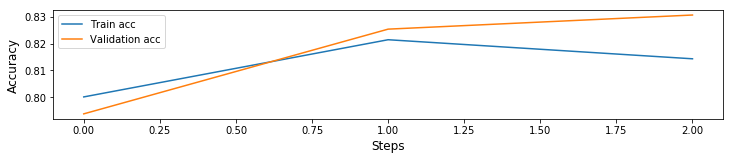

In [74]:
plt.figure(figsize=(12, 2))
plt.plot(train_acc)
plt.plot(valid_acc)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train acc', 'Validation acc'], fontsize=10, loc='upper left')
plt.show()

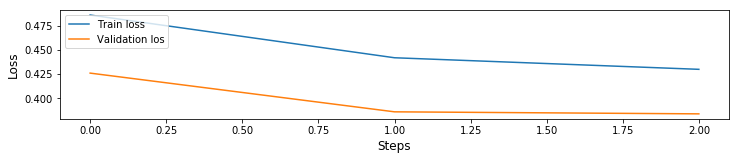

In [75]:
plt.figure(figsize=(12, 2))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train loss', 'Validation los'], fontsize=10, loc='upper left')
plt.show()

## Create submission file

In [76]:
# create kaggle submission file
# in predict mode model returns generator
predict_generator = dnn_classifier.predict(input_fn=predict_input_fn)

# create list of dict like {class:class, probability:probability}
predict_dictlist = [next(predict_generator) for i in range(len(test_examples))]

# for kaggle we need only classes
classes = [predict_dictlist[item]['classes'] for item in range(len(predict_dictlist))]

# function to create pandas df
def create_mnist_submission_df(class_predictions, file_name):
    submission_df = pd.DataFrame()
    submission_df['PassengerId'] = pd.read_csv('test.csv')['PassengerId']
    submission_df['Survived'] = class_predictions
    submission_df.set_index('PassengerId', inplace=True)
    submission_df.to_csv(file_name)
    print('Saved predictions to ', file_name)

create_mnist_submission_df(classes, 'submission_titanic.csv')

Saved predictions to  submission_titanic.csv
